<a href="https://colab.research.google.com/github/seongwoojang1123/TMJ-osteoarthritis-diagnosis-/blob/main/6_Case_Delong's_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

P-value Heatmap

Delong's Test P-Value Table:
                                     CBCT1,3   CBCT2,4  \
CBCT1,3                             0.000000  0.805486   
CBCT2,4                             0.805486  0.000000   
CBCT1,2,3,4 combining               0.887226  0.697947   
MRI1,2                              0.986594  0.818520   
MRI3,4                              0.959736  0.844795   
MRI1,2,3,4 combining                0.116985  0.186505   
CBCT1,3 + CBCT2,4 Fine Tuning       0.740653  0.563713   
CBCT2,4 + CBCT1,3 Fine Tuning       0.803282  0.620308   
CBCT1,3 + MRI1,2 Fine Tuning        0.488156  0.347293   
CBCT2,4 + MRI3,4 Fine Tuning        0.825475  0.979463   
MRI1,2 + CBCT1,3 Fine Tuning        0.444514  0.311885   
MRI3,4 + CBCT2,4 Fine Tuning        0.513460  0.368105   
CBCT1,3 + CBCT2,4 ensemble          0.370743  0.516554   
CBCT2,4 + CBCT1,3 ensemble          0.448495  0.608963   
CBCT1,3 + MRI1,2 ensemble           0.939977  0.747783   
CBCT2,4 + MRI3,4 ensemble           0.91351

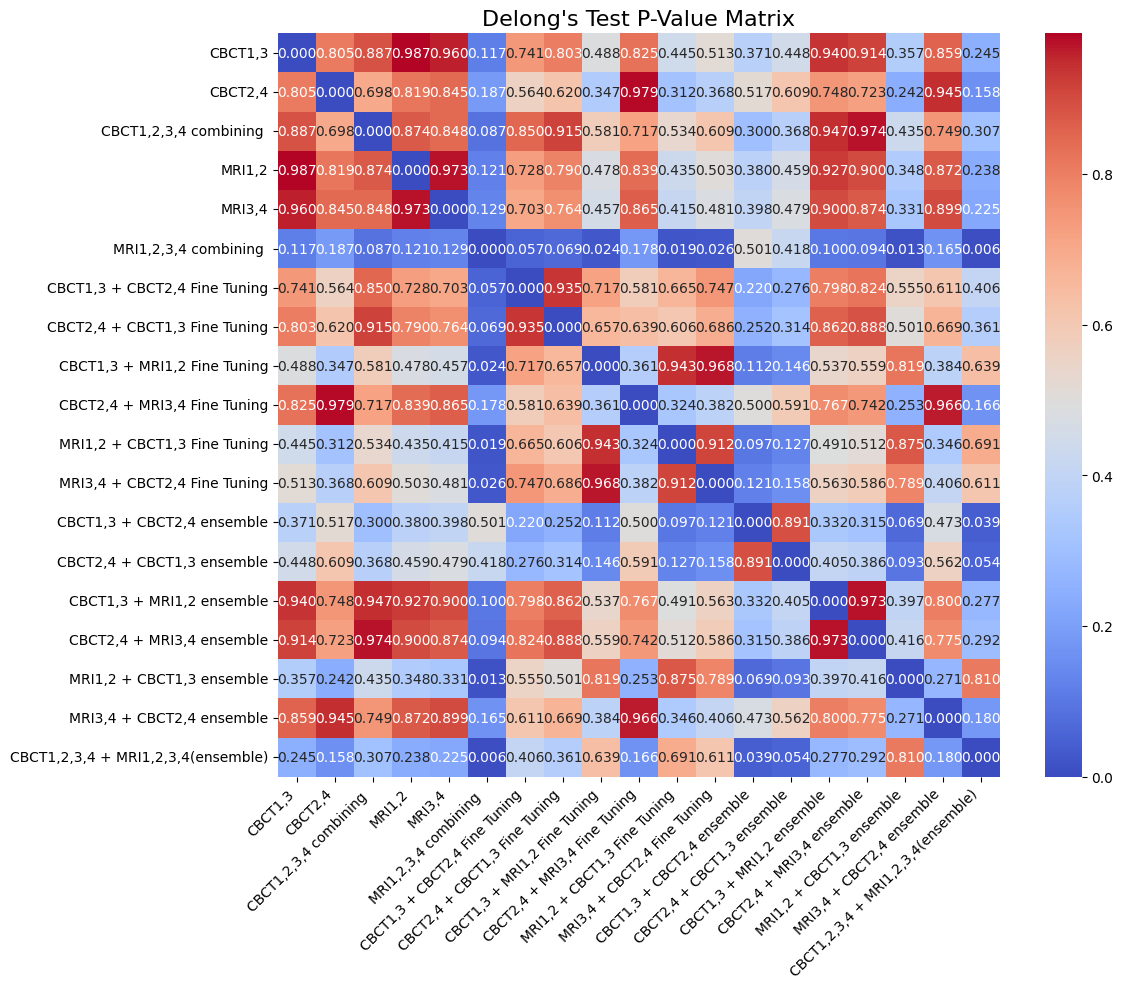

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

# AUROC 데이터 입력
auroc_data = {
    "CBCT1,3": [0.768, 0.771],
    "CBCT2,4": [0.781, 0.787],
    "CBCT1,2,3,4 combining ": [0.756, 0.766],
    "MRI1,2": [0.706, 0.835],
    "MRI3,4": [0.718, 0.827],
    "MRI1,2,3,4 combining ": [0.830, 0.881],
    "CBCT1,3 + CBCT2,4 Fine Tuning": [0.742, 0.757],
    "CBCT2,4 + CBCT1,3 Fine Tuning": [0.737, 0.772],
    "CBCT1,3 + MRI1,2 Fine Tuning": [0.655, 0.799],
    "CBCT2,4 + MRI3,4 Fine Tuning": [0.726, 0.839],
    "MRI1,2 + CBCT1,3 Fine Tuning": [0.714, 0.731],
    "MRI3,4 + CBCT2,4 Fine Tuning": [0.717, 0.742],
    "CBCT1,3 + CBCT2,4 ensemble": [0.809, 0.832],
    "CBCT2,4 + CBCT1,3 ensemble": [0.795, 0.831],
    "CBCT1,3 + MRI1,2 ensemble": [0.801, 0.729],
    "CBCT2,4 + MRI3,4 ensemble": [0.667, 0.859],
    "MRI1,2 + CBCT1,3 ensemble": [0.798, 0.627],
    "MRI3,4 + CBCT2,4 ensemble": [0.709, 0.851],
    "CBCT1,2,3,4 + MRI1,2,3,4(ensemble)": [0.826, 0.568],
}

# AUROC 데이터를 DataFrame으로 변환
auroc_df = pd.DataFrame(auroc_data, index=["Baseline", "NEW Images"]).T

# Delong's Test 계산 함수
def delongs_test(auroc1, auroc2, n=100):
    """
    Delong's Test를 통해 두 AUROC 값의 p-value 계산
    """
    diff = auroc1 - auroc2
    std_error = np.sqrt((auroc1 * (1 - auroc1) + auroc2 * (1 - auroc2)) / n)
    z_score = diff / std_error
    p_value = 2 * (1 - norm.cdf(abs(z_score)))
    return p_value

# p-value 매트릭스 생성
cases = auroc_df.index.tolist()
n_cases = len(cases)
auroc_values = auroc_df.values
p_value_matrix = np.zeros((n_cases, n_cases))

for i, j in combinations(range(n_cases), 2):
    valid_indices = ~np.isnan(auroc_values[[i, j], :]).any(axis=0)
    if valid_indices.any():
        p_value_matrix[i, j] = delongs_test(
            np.mean(auroc_values[i, valid_indices]),
            np.mean(auroc_values[j, valid_indices]),
        )
        p_value_matrix[j, i] = p_value_matrix[i, j]

p_value_df = pd.DataFrame(p_value_matrix, index=cases, columns=cases)

# p-value 테이블 출력
print("Delong's Test P-Value Table:")
print(p_value_df)

# p-value 테이블 저장
p_value_df.to_csv("Delongs_Test_P_Value_Matrix.csv")

# p-value 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(p_value_df, annot=True, fmt=".3f", cmap="coolwarm", cbar=True,
            xticklabels=p_value_df.columns, yticklabels=p_value_df.index)
plt.title("Delong's Test P-Value Matrix", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# 히트맵 저장
plt.savefig("Delongs_Test_P_Value_Heatmap.png")
plt.show()

Delong'Test

In [1]:
import os
import cv2
import pickle
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, roc_auc_score, accuracy_score
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import AUC

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Class weights: {0: np.float64(0.8576642335766423), 1: np.float64(1.1989795918367347)}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 69s 778ms/step - accuracy: 0.5234 - auc: 0.5221 - loss: 0.8186 - val_accuracy: 0.4036 - val_auc: 0.5098 - val_loss: 1.8089 - learning_rate: 1.0000e-04
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 308ms/step - accuracy: 0.5026 - auc: 0.4895 - loss: 0.7801 - val_accuracy: 0.4036 - val_auc: 0.5154 - val_loss: 2.6951 - learning_rate: 1.0000e-04
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 301ms/step - accuracy: 0.4858 - auc: 0.4984 - loss: 0.7436 - val_accuracy: 0.5964 - val_auc: 0.5000 - val_loss: 2.7467 - learning_rate: 1.0000e-04
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 316ms/step - accuracy: 0.5260 - auc: 0.5349 - loss: 0.7402 - val_accuracy: 0.5964 - val_auc: 0.5676 - val_loss: 1.3624 - learning_rate: 1.0000e-04
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 348ms/step - accuracy: 0.5075 - auc: 0.5080 - loss: 0.7450 - val_accuracy: 0.5964 - val_auc: 0.5905 - val_loss: 1.8491 - learning_rate: 1.0000e-04
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 342ms/step - 

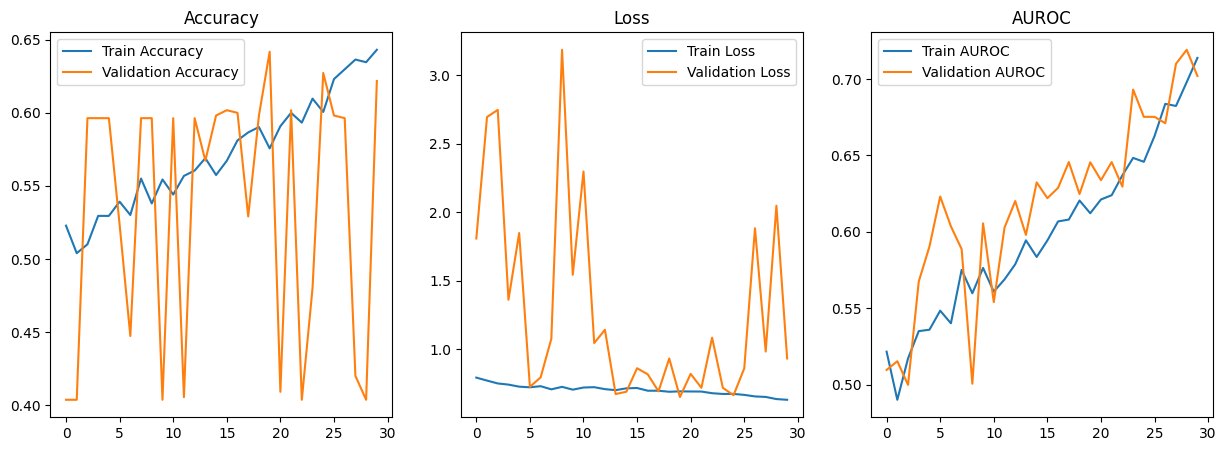

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.2555 - auc: 0.5381 - loss: 2.5995
Test Loss: 2.0395, Test Accuracy: 0.4145, Test AUROC: 0.6899
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step
Optimal Threshold: 0.9811


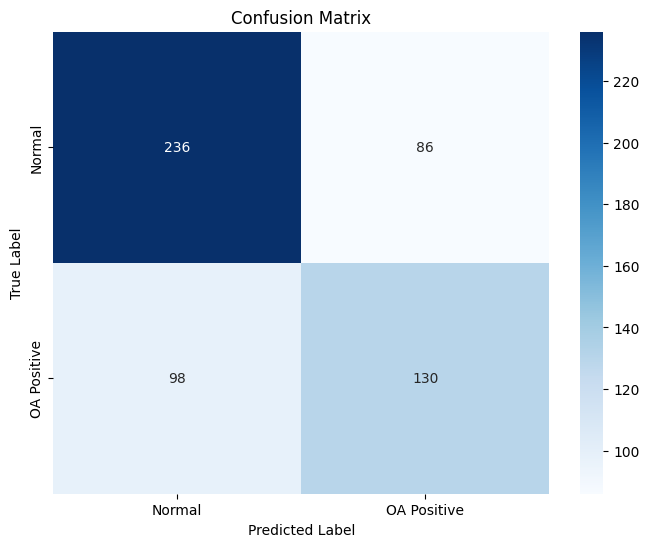

Confusion Matrix:
 [[236  86]
 [ 98 130]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.73      0.72       322
           1       0.60      0.57      0.59       228

    accuracy                           0.67       550
   macro avg       0.65      0.65      0.65       550
weighted avg       0.66      0.67      0.66       550



In [2]:
# 랜덤 시드 설정
seed = 42  # 고정된 랜덤 시드 값
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# 피클 파일 로드
with open('/content/drive/MyDrive/TMJ OA/기존 CBCT 1,3 + NEW CBCT 1,2/tmj_oa_CBCT1,3 + NEW_dataset_1.pkl', 'rb') as f:
    dataset = pickle.load(f)

# 데이터셋 분리
train_images = dataset['train_data']['image']
train_labels = dataset['train_data']['label']
val_images = dataset['validation_data']['image']
val_labels = dataset['validation_data']['label']
test_images = dataset['test_data']['image']
test_labels = dataset['test_data']['label']

# 데이터 증강 생성기 설정
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='reflect'
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# 데이터 증강 생성기를 통해 데이터 생성
train_generator = train_datagen.flow(
    train_images, train_labels, batch_size=32, shuffle=True, seed=seed
)

val_generator = val_datagen.flow(
    val_images, val_labels, batch_size=32, shuffle=False, seed=seed
)

test_generator = test_datagen.flow(
    test_images, test_labels, batch_size=32, shuffle=False, seed=seed
)

# VGG16 모델 구성
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(140, 140, 3))
for layer in base_model.layers[:-8]:
    layer.trainable = True
    layer.kernel_initializer = GlorotUniform(seed=seed)

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# 클래스 가중치 계산
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = dict(enumerate(class_weights))
#class_weights = {0: 0.7, 1: 1.5}  # 클래스 1에 더 높은 가중치 부여
print("Class weights:", class_weights)


# 콜백 설정
early_stopping = EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_vgg16_auroc.keras', save_best_only=True, monitor='val_auc', mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=7, mode='max', min_lr=1e-6)

# 모델 학습
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# 학습 결과 시각화
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUROC')
plt.plot(history.history['val_auc'], label='Validation AUROC')
plt.legend()
plt.title('AUROC')
plt.show()

# 테스트 데이터 평가
test_loss, test_accuracy, test_auc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUROC: {test_auc:.4f}")

# ROC Curve
y_pred = model.predict(test_generator).flatten()
fpr, tpr, thresholds = roc_curve(test_labels, y_pred)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.4f}")

# Confusion Matrix
y_pred_adjusted = (y_pred >= optimal_threshold).astype(int)
#y_pred_adjusted = (y_pred >= 0.4).astype(int)  # 임계값을 약간 높임
conf_matrix = confusion_matrix(test_labels, y_pred_adjusted)

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "OA Positive"], yticklabels=["Normal", "OA Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(test_labels, y_pred_adjusted))

#model.save('/content/drive/MyDrive/TMJ OA/NEW_MRI1,2,3,4_model.keras')

In [4]:
import pandas as pd

test_patient_ids = dataset['test_data']['patient_id']
test_sides = dataset['test_data']['side']
true_labels_in_order = dataset['test_data']['label'] # 원본 test_labels 사용

image_ids = [f"{pid}_{side}" for pid, side in zip(test_patient_ids, test_sides)]

delong_df = pd.DataFrame({
    'Image_ID': image_ids,
    'True_Label': true_labels_in_order,
    'Prediction_Score': y_pred
})

# CSV 파일로 저장
csv_path = '/content/drive/MyDrive/TMJ OA/Delong_test/delong_test_data_NEW_CBCT1,3.csv'
delong_df.to_csv(csv_path, index=False)

print("\n" + "="*50)
print(f"Delong's Test를 위한 데이터가 최종적으로 저장되었습니다.")
print(f"파일 경로: {csv_path}")
print("파일 내용 미리보기:")
print(delong_df.head())
print("="*50)


Delong's Test를 위한 데이터가 최종적으로 저장되었습니다.
파일 경로: /content/drive/MyDrive/TMJ OA/Delong_test/delong_test_data_NEW_CBCT1,3.csv
파일 내용 미리보기:
      Image_ID  True_Label  Prediction_Score
0  14003185_Lt           0          0.867223
1  12725494_Lt           0          0.910004
2  14976260_Lt           0          0.987078
3  11880794_Lt           0          0.974088
4  15024738_Lt           0          0.969055



── AUC ± 95 % CI ──
                AUC    CI_low   CI_high
Condition                              
CBCT1,3    0.738950  0.689435  0.788464
CBCT2,4    0.758915  0.710934  0.806896
MRI1,2     0.668845  0.538471  0.799219
MRI3,4     0.676923  0.545110  0.808736

── Pairwise unpaired z-tests (FDR-adjusted) ──
        Comparison  z_stat  p_raw  p_FDR
 CBCT1,3 vs MRI1,2  0.9853 0.3245 0.5819
 CBCT1,3 vs MRI3,4  0.8634 0.3879 0.5819
 CBCT2,4 vs MRI1,2   1.271 0.2038 0.5819
 CBCT2,4 vs MRI3,4   1.146 0.2519 0.5819
CBCT1,3 vs CBCT2,4 -0.5676 0.5703 0.6844
  MRI1,2 vs MRI3,4 -0.0854 0.9319 0.9319


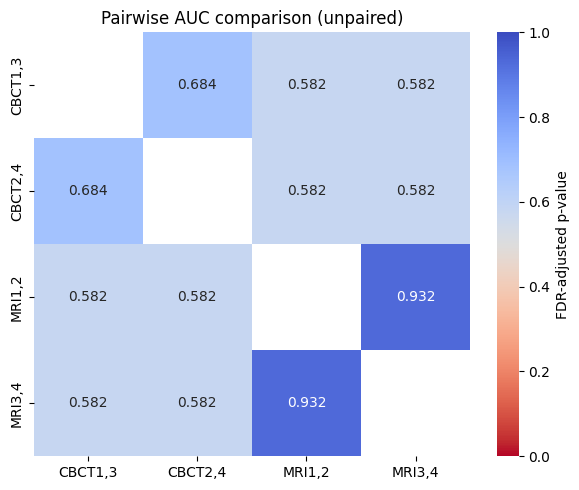

In [5]:
# ---------------------------------------------------------------
#  Unpaired ROC-AUC comparison for four independent test sets
#    Hanley-McNeil variance  +  FDR-adjusted p-values
# ---------------------------------------------------------------

import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.metrics import roc_auc_score
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

# ── 1. 파일 경로와 읽기 ───────────────────────────────────────
file_paths = {
    "CBCT1,3": "/content/drive/MyDrive/TMJ OA/Delong_test/delong_test_data_CBCT1,3.csv",
    "CBCT2,4": "/content/drive/MyDrive/TMJ OA/Delong_test/delong_test_data_CBCT2,4.csv",
    "MRI1,2":  "/content/drive/MyDrive/TMJ OA/Delong_test/delong_test_data_MRI1,2.csv",
    "MRI3,4":  "/content/drive/MyDrive/TMJ OA/Delong_test/delong_test_data_MRI3,4.csv",
}

data = {}
for name, path in file_paths.items():
    df = pd.read_csv(path)
    data[name] = {
        "y_true":  df["True_Label"].values,
        "y_pred":  df["Prediction_Score"].values,
    }

# ── 2. Hanley-McNeil 표준오차 함수 ───────────────────────────
def auc_se_hanley(y_true, y_score):
    auc  = roc_auc_score(y_true, y_score)
    n1   = (y_true == 1).sum()      # positives
    n0   = (y_true == 0).sum()      # negatives
    q1   = auc / (2 - auc)
    q2   = 2 * auc**2 / (1 + auc)
    var  = (auc*(1-auc) + (n1-1)*(q1-auc**2) + (n0-1)*(q2-auc**2)) / (n1*n0)
    return auc, np.sqrt(var)

# ── 3. 각 조건 AUC·SE·CI 계산 ───────────────────────────────
summary_rows = []
for name, d in data.items():
    auc, se = auc_se_hanley(d["y_true"], d["y_pred"])
    ci_low, ci_high = auc - 1.96*se, auc + 1.96*se
    summary_rows.append([name, auc, ci_low, ci_high, se,
                         len(d["y_true"][(d["y_true"]==1)]),
                         len(d["y_true"][(d["y_true"]==0)])])

summary = pd.DataFrame(summary_rows,
                       columns=["Condition", "AUC", "CI_low", "CI_high",
                                "SE", "n_pos", "n_neg"]).set_index("Condition")
print("\n── AUC ± 95 % CI ──")
print(summary[["AUC", "CI_low", "CI_high"]])

# ── 4. 쌍 비교(unpaired) z-test ─────────────────────────────
pairs, z_vals, p_vals = [], [], []
for (a, d1), (b, d2) in combinations(data.items(), 2):
    auc1, se1 = auc_se_hanley(d1["y_true"], d1["y_pred"])
    auc2, se2 = auc_se_hanley(d2["y_true"], d2["y_pred"])
    diff   = auc1 - auc2
    se_diff = np.sqrt(se1**2 + se2**2)        # 독립 가정 ⇒ 공분산 0
    z      = diff / se_diff
    p      = 2 * (1 - norm.cdf(abs(z)))       # two-sided
    pairs.append(f"{a} vs {b}")
    z_vals.append(z)
    p_vals.append(p)

# ── 5. 다중 비교 보정(FDR) ──────────────────────────────────
adj_p = multipletests(p_vals, method="fdr_bh")[1]

pair_df = pd.DataFrame({
    "Comparison": pairs,
    "z_stat": z_vals,
    "p_raw": p_vals,
    "p_FDR": adj_p,
}).sort_values("p_FDR")
print("\n── Pairwise unpaired z-tests (FDR-adjusted) ──")
print(pair_df.to_string(index=False, float_format="%.4g"))

pair_df.to_csv("AUC_unpaired_ztest_results.csv", index=False)

# ── 6. p-value 히트맵(보정 후) ──────────────────────────────
cond_names = list(file_paths.keys())
p_mat = np.zeros((len(cond_names), len(cond_names)))
for (a, b), p in zip(combinations(range(len(cond_names)), 2), adj_p):
    p_mat[a, b] = p_mat[b, a] = p
np.fill_diagonal(p_mat, np.nan)

plt.figure(figsize=(6,5))
sns.heatmap(pd.DataFrame(p_mat, index=cond_names, columns=cond_names),
            annot=True, fmt=".3f", cmap="coolwarm_r", vmin=0, vmax=1,
            cbar_kws={'label': 'FDR-adjusted p-value'})
plt.title("Pairwise AUC comparison (unpaired)")
plt.tight_layout()
plt.savefig("AUC_unpaired_pvalue_heatmap.png", dpi=300)
plt.show()
